Here we will look into data from nine countries [
    Netherlands, 
    France, 
    Italy, 
    United Kingdom, 
    Spain, 
    Turkey,
    Canada,
    Portugal,
    Germany
] and four USA states [New York, New Jersey, Georgia, Michigan].

In [1]:
import jax.numpy as np
import numpy as onp

import matplotlib.pyplot as plt
import seaborn as sns

from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.handlers import substitute, condition

sns.set(style='white', context='notebook', palette='muted')

In [2]:
import pandas as pd

df_global = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv", 
                        usecols=[
                            'day',
                            'month',
                            'year',
                            'cases',
                            'deaths',
                            'countriesAndTerritories'
                        ],
                        parse_dates=False)

date = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df_global.year, df_global.month, df_global.day)])
df_global = df_global.drop(columns=['day', 'month', 'year'])
df_global.columns = ['Cases', 'Deaths', 'Countries']
df_global['Date'] = date
df_global['Countries'].replace('United_Kingdom', 'United Kingdom', inplace=True)
df_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21338 entries, 0 to 21337
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Cases      21338 non-null  int64         
 1   Deaths     21338 non-null  int64         
 2   Countries  21338 non-null  object        
 3   Date       21338 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 666.9+ KB


In [3]:
onp.unique(df_global['Countries'])

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua_and_Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius and Saba', 'Bosnia_and_Herzegovina',
       'Botswana', 'Brazil', 'British_Virgin_Islands',
       'Brunei_Darussalam', 'Bulgaria', 'Burkina_Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape_Verde',
       'Cases_on_an_international_conveyance_Japan', 'Cayman_Islands',
       'Central_African_Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo', 'Costa_Rica', 'Cote_dIvoire', 'Croatia',
       'Cuba', 'Curaçao', 'Cyprus', 'Czechia',
       'Democratic_Republic_of_the_Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican_Republic', 'Ecuador', 'Egypt',
       'El_Salvador', 'Equatorial_Guinea', 'Eri

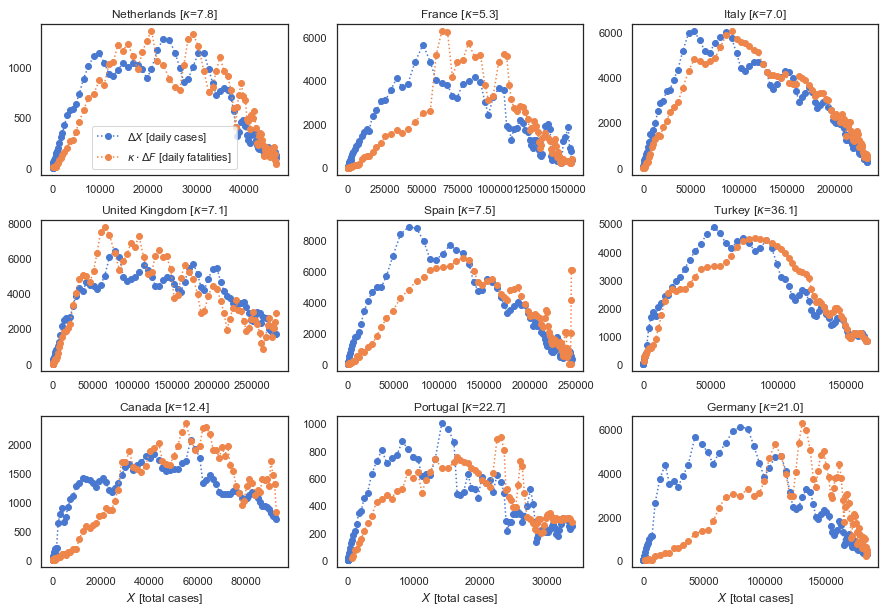

In [4]:
countries = [
    'Netherlands', 
    'France', 
    'Italy', 
    'United Kingdom', 
    'Spain', 
    'Turkey',
    'Canada',
    'Portugal',
    'Germany'
]

dX = df_global.pivot(index='Date', columns='Countries', values='Cases').loc[:, countries].iloc[51:]
dF = df_global.pivot(index='Date', columns='Countries', values='Deaths').loc[:, countries].iloc[51:]

# fill negative vallues with a value from the previous day
dX = dX.fillna(0.).where(dX.fillna(0.) > 0).fillna(method='ffill')
dF = dF.fillna(0.).where(dF.fillna(0.) > 0).fillna(method='ffill')
kappa = (dX.where(dX >= 1.).cumsum().iloc[-1]/dF.where(dF >= 1.).cumsum().iloc[-1])

#onp.exp(onp.log(dX.where(dX > 1.).iloc[-50:]).mean()- onp.log(dF.where(dF > 1.).iloc[-50:]).mean())

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
ax = axes.flatten()

for i, name in enumerate(countries):
    
    dXs = dX[name].rolling(window=3, center=True, win_type='gaussian').mean(std=2.6)
    dFs = dF[name].rolling(window=3, center=True, win_type='gaussian').mean(std=2.6)
    ax[i].plot(dXs.cumsum(), dXs, ':o', label=r'$\Delta X$ [daily cases]')
    ax[i].plot(dXs.cumsum(), dFs * kappa[name], ':o', label=r'$\kappa \cdot \Delta F$ [daily fatalities]')
    ax[i].set_title(name + r' [$\kappa$={:02.1f}]'.format(kappa[name]))
    if i > 5:
        ax[i].set_xlabel(r'$X$ [total cases]')
    
ax[0].legend();

fig.subplots_adjust(hspace=.3)
fig.savefig('cases_deaths_representation.pdf', bbox_inches='tight', transparent=True, dpi=300)

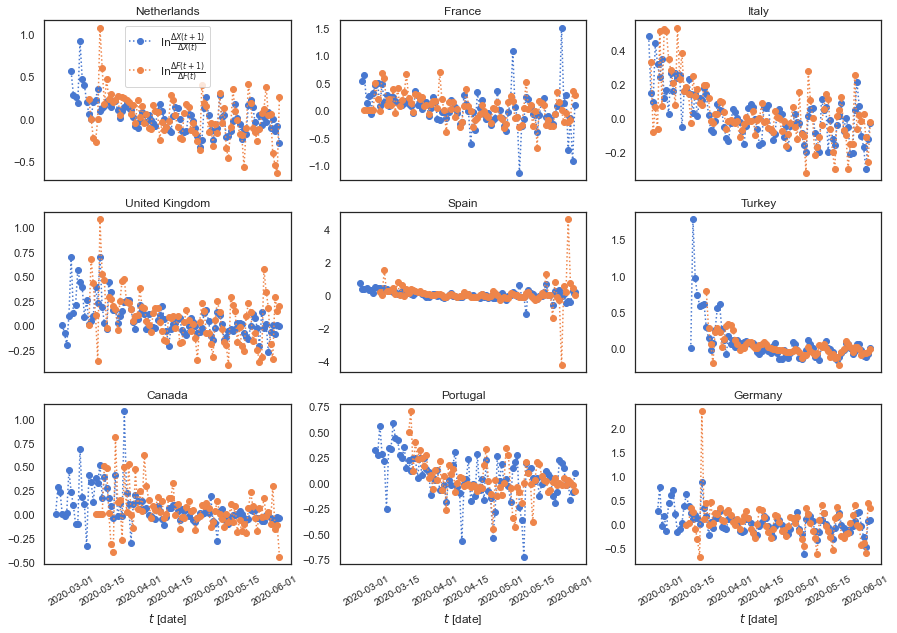

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
ax = axes.flatten()

for i, name in enumerate(countries):
    
    dXs = dX[name].rolling(window=3, center=True, win_type='gaussian').mean(std=2.6)
    dFs = dF[name].rolling(window=3, center=True, win_type='gaussian').mean(std=2.6)
    ax[i].plot(onp.log(dXs).diff(), ':o', label=r'$\ln \frac{\Delta X(t+1)}{\Delta X(t)}$')
    ax[i].plot(onp.log(dFs).diff(), ':o', label=r'$\ln \frac{\Delta F(t+1)}{\Delta F(t)}$')
    ax[i].set_title(name)
    if i > 5:
        ax[i].xaxis.set_tick_params(rotation=30, labelsize=10)
        ax[i].set_xlabel(r'$t$ [date]')
    
ax[0].legend();
fig.savefig('cases_deaths_validation.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [6]:
# data from worldometer on May 17 2020
population = [17134872, 65273511, 60461826, 67886011, 46754778, 84339067, 37742154, 10196709, 83783942]
population = pd.DataFrame({'Population':population, 'Country':countries})

In [7]:
# implementation of the inference for XI relationship from daily fatalities

import numpyro as npyro
import numpyro.distributions as dist
from numpyro.distributions.transforms import ( 
    AffineTransform, 
    ExpTransform, 
    IdentityTransform, 
    ComposeTransform
)

from numpyro.distributions import constraints

def fun_g(X, I, aX, aI, g0):
    return g0/(1 + aX * X + aI * I)

def fun_I(x, kX, kI, g0):
    par1 = (1 + kX)/ (1 - kI)
    par2 = 1./(g0 * kI) + kX / kI
    
    return par1 * x + (par1 + par2) * (np.exp(np.log(1 - x) * kI) - 1)

def model(data, obs=None):
    """
    :param int T: number of measured data points
    :param numpy.ndarray N: total population size for different categories with shape (K,)
    :param pandas.DataFrame data: collected data for X, I, D
    :param numpy.ndarray obs: 
    """
    
    # infer the fraction of the total population that can be infected. With this we also assume a possible 
    # presence of social, biological or geographical barriers to the disease spreading.

    X_data = data['X']
    dF_data = data['dF']
    N = data['N']
    kappa = data['kappa']
    
    T, K = X_data.shape
    
    g0_hyp = np.array([3., 2.])
    f_hyp = np.array([2., 4.])
    s_hyp = np.array([2., 1.])
    
    k_I = npyro.param('k_I', np.ones(K) * 500., constraint=constraints.positive)
    k_X = npyro.param('k_X', np.ones(K) * 10., constraint=constraints.positive)
    
    with npyro.plate('countries', K):
        f = npyro.sample('f', dist.Gamma(*f_hyp))
        norm = npyro.deterministic('nf', f * N)
        
        gamma = npyro.sample('gamma', dist.Gamma(10., 10.))
        g0 = npyro.sample('g0', dist.Gamma(*g0_hyp))
        
        n_X = X_data/norm

        n_I = fun_I(n_X, k_X, k_I, g0)
        npyro.deterministic('I', norm * np.where(n_I > 0., n_I, 0.))
        
        a_X = npyro.deterministic('a_X', g0 * k_X)
        a_I = npyro.deterministic('a_I', g0 * k_I)
    
        g_t = npyro.deterministic('g_t', fun_g(n_X, n_I, a_X, a_I, g0))
        
        dF = npyro.deterministic('dF', norm * n_I / kappa)
        
        npyro.deterministic('tau', 1 / gamma)
        npyro.deterministic('p', gamma / kappa)
        
        scale1 = npyro.sample('scale1', dist.InverseGamma(*s_hyp))
        scale2 = npyro.sample('scale2', dist.InverseGamma(*s_hyp))
        
        x_t = npyro.deterministic('x_t', gamma * (g_t * (1-n_X) - 1))
        with npyro.plate('data_1', T-1):
            dist1 = dist.StudentT(10., 0., 1.)
            aff1 = AffineTransform(x_t[:-1], np.sqrt(scale1))
            trans_dist1 = dist.TransformedDistribution(dist1, aff1)
            npyro.sample("obs1", trans_dist1.mask(data['mask_1']), obs=obs)
            
        with npyro.plate('data_2', T):
            dist2 = dist.StudentT(2., 0., 1.)
            aff2 = AffineTransform(dF, np.sqrt(scale2))
            trans_dist2 = dist.TransformedDistribution(dist2, aff2)
            npyro.sample("obs2", trans_dist2.mask(data['mask_2']), obs=dF_data)

In [8]:
import numpy as onp

w = 3

dXs = dX.rolling(window=2 * w + 1, center=True, win_type='gaussian').mean(std=2.6).iloc[3+w:-w]
Xs = dXs.cumsum()
mask_2 = ~np.isnan(Xs.values)

dFs = dF.rolling(window=2 * w + 1, center=True, win_type='gaussian').mean(std=2.6).iloc[3+w:-w]
obs = onp.log(dXs).diff().values[1:]
mask_1 = ~np.isnan(obs)
obs = np.nan_to_num(obs)

N = population.set_index('Country').loc[countries].Population.values.astype(np.float32)

data = {
    'N': N,
    'kappa': np.array(kappa.values),
    'mask_1': mask_1,
    'mask_2': mask_2,
    'X': np.array(Xs.fillna(0.).values),
    'dF': np.array(dFs.where(dFs > 1., 1.).values) 
}

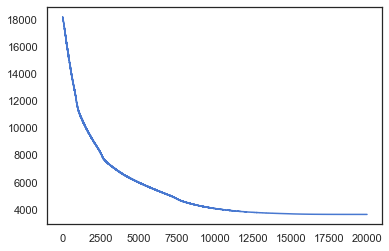

In [9]:
from numpyro import optim
from numpyro.infer import SVI, ELBO
from jax import random, lax

from numpyro.contrib.autoguide import AutoMultivariateNormal, AutoDiagonalNormal, AutoLaplaceApproximation, AutoContinuousELBO

# variational inference with approximate posterior
num_iters = 20000
num_samples = 1000

cmodel = condition(model, {'f': 1.})
# guide =  AutoDiagonalNormal(cmodel)
# guide = AutoLaplaceApproximation(cmodel)
guide = AutoMultivariateNormal(cmodel)

svi = SVI(cmodel, guide, optim.Adam(0.0005), AutoContinuousELBO(num_particles=500))
svi_state = svi.init(random.PRNGKey(10101), data, obs=obs)

last_state, losses = lax.scan(lambda state, i: svi.update(state, data, obs=obs), 
                              svi_state, 
                              np.zeros(num_iters))

params = svi.get_params(last_state)
post_sample = guide.sample_posterior(random.PRNGKey(0), params, sample_shape=(num_samples,))

return_sites = ['a_X', 'a_I', 'g0', 'g_t', 'tau', 'x_t', 'dF', 'f', 'I', 'scale']
predict = Predictive(cmodel, 
                     guide=guide, 
                     posterior_samples=post_sample,
                     params=params, 
                     num_samples=num_samples, 
                     return_sites=return_sites)
sample = predict(random.PRNGKey(0), data, obs=obs)
plt.plot(losses)

In [11]:
print(params['k_I'], params['k_X'])

[ 164.57852    52.77906   509.27487  1403.3865    108.04863  1020.2987
   26.245792  627.7985     28.275358] [73.77628  98.43796  43.98774  48.241333 34.97664  98.82366  43.096542
 40.05861  72.36554 ]


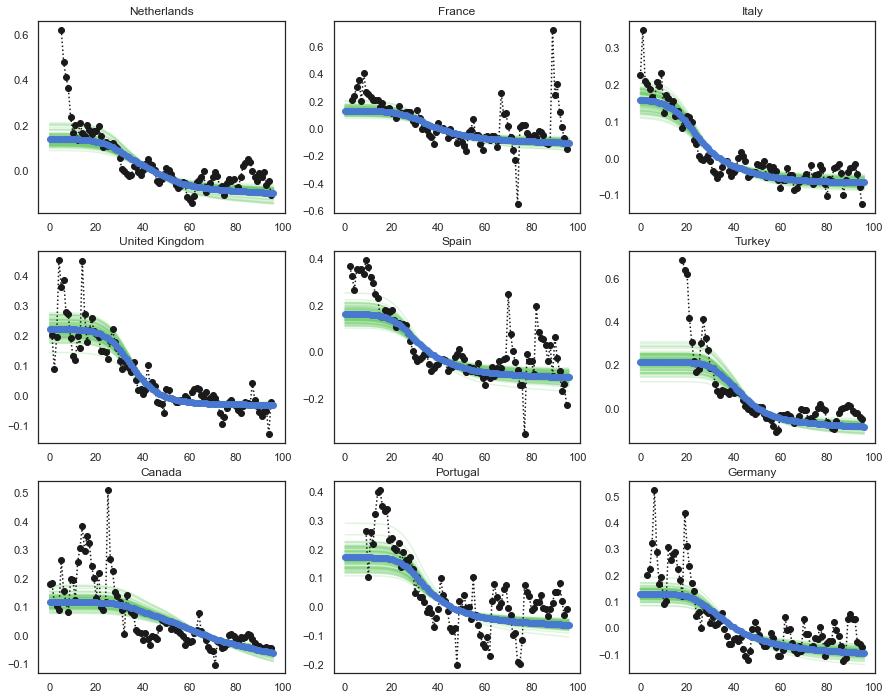

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
ax = axes.flatten()
post_x_t = sample['x_t']
for i, country in enumerate(countries):
    ax[i].plot(post_x_t.mean(0)[:, i], 'bo', lw=3, zorder=10)
    ax[i].plot(post_x_t[:100, :, i].T, 'g-', alpha=.2)
    ax[i].plot(onp.log(dXs[country]).diff().values[1:], 'ko:')
    
    ax[i].set_title(country)

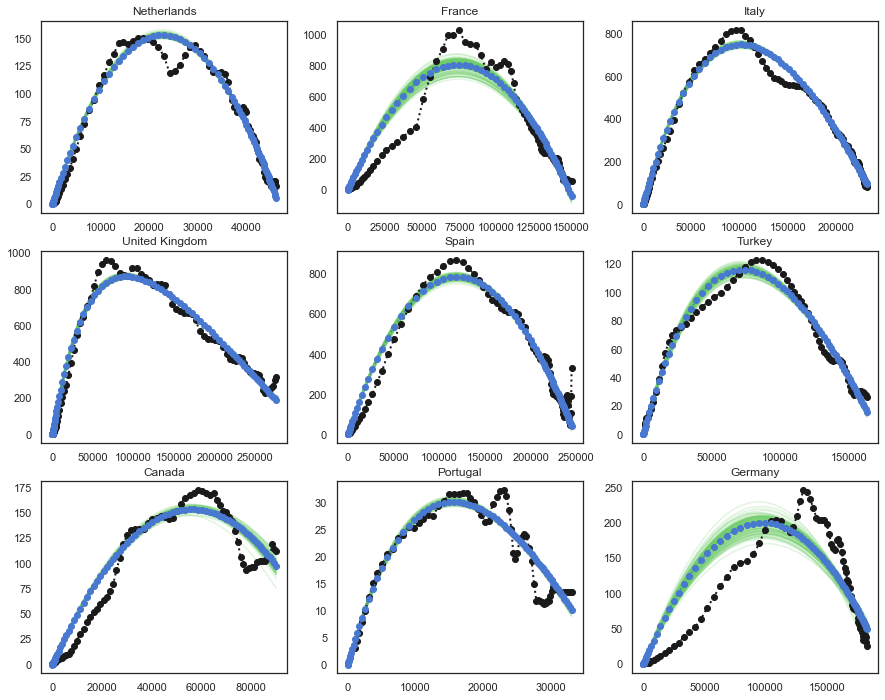

In [209]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
ax = axes.flatten()
post_dF = sample['dF']
for i, country in enumerate(countries):
    ax[i].plot(Xs[country], post_dF.mean(0)[:, i], 'bo:', zorder=10)
    ax[i].plot(Xs[country], post_dF[:100, :, i].T, 'g-', alpha=.2)

    ax[i].plot(Xs[country], dFs[country], 'ko:', lw=2);
    ax[i].set_title(country)

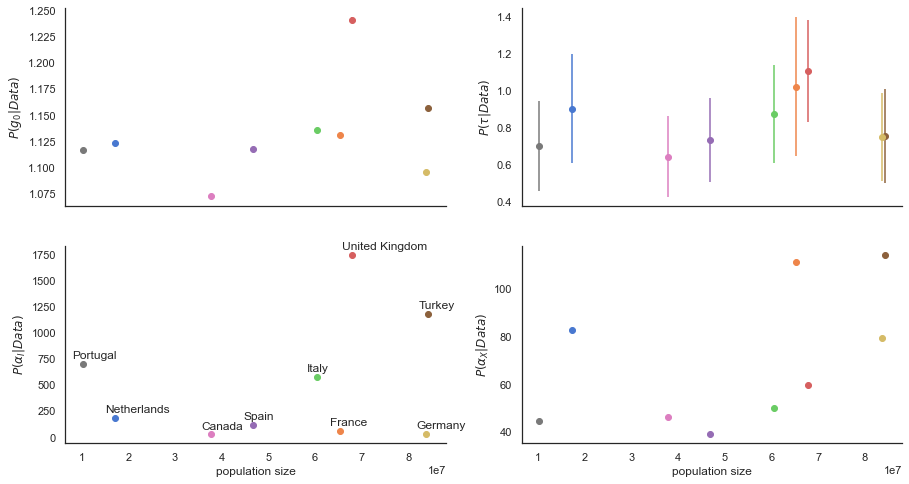

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharex=True)

for i, n in enumerate(population.Population):
    axes[0, 0].errorbar(n, sample['g0'].mean(0)[i], yerr=2*sample['g0'].std(0)[i], marker='o', linestyle='')
    axes[0, 1].errorbar(n, sample['tau'].mean(0)[i], yerr=2*sample['tau'].std(0)[i], marker='o', linestyle='')
    axes[1, 0].errorbar(n, sample['a_I'].mean(0)[i], yerr=2*sample['a_I'].std(0)[i], marker='o', linestyle='')
    axes[1, 1].errorbar(n, sample['a_X'].mean(0)[i], yerr=2*sample['a_X'].std(0)[i], marker='o', linestyle='')

axes[0,0].set_ylabel(r'$P(g_0|Data)$')
axes[0, 1].set_ylabel(r'$P(\tau|Data)$')
axes[1, 0].set_ylabel(r'$P(\alpha_I|Data)$')
axes[1, 1].set_ylabel(r'$P(\alpha_X|Data)$')
axes[1, 0].set_xlabel('population size');
axes[1, 1].set_xlabel('population size');

sns.despine(fig=fig, ax=axes)

for i, country in enumerate(population.Country):
    height = sample['a_I'].mean(0)[i]
    axes[1, 0].annotate(country,
                        xy=(population.Population.iloc[i], height),
                        xytext=(-10, 3),  # use 3 points offset
                        textcoords="offset points",  # in both directions
                        ha='left', va='bottom')
    
fig.savefig('posterior_estimates.pdf', bbox_inches='tight', transparent=True, dpi=300)

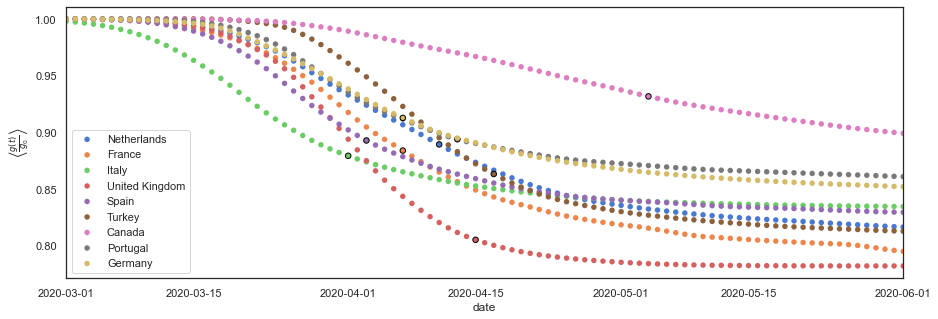

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
prob = np.diff(np.mean(sample['g_t'] < 1., 0) > .5, axis=0)
ecol = np.concatenate([np.zeros((1, len(countries))), prob], 0)
ecol = onp.array(ecol.astype(np.int32))
colors = onp.array([[0., 0., 0., 0.], [0., 0., 0., 1.]])[ecol]
post_g_t_norm = sample['g_t']/np.expand_dims(sample['g0'], -2)
for i, country in enumerate(countries):
    ax.scatter(Xs.index, post_g_t_norm.mean(0)[:, i], s=30, label=country, edgecolors=colors[:, i])
    
ax.legend()
ax.set_xlim([pd.to_datetime('2020-03-01'), pd.to_datetime('2020-06-01')])
ax.set_ylabel(r'$\left\langle \frac{g(t)}{g_0} \right\rangle$')
ax.set_xlabel('date')

fig.savefig('normalized_g_t.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [230]:
sample_nuts = {}
for i, country in enumerate(countries):
    print(country)
    Nc = data['N'][i:i+1]
    kc = data['kappa'][i:i+1]
    c_data = {}
    for key in data:
        if len(data[key].shape) > 1:
            c_data[key] = data[key][:, i:i+1]
    
    c_data['kappa'] = kc
    c_data['N'] = Nc
    num_warmup = 1000
    num_samples = 1000

    nuts = NUTS(condition(model, {'f': 1.}), target_accept_prob=.95, max_tree_depth=12)
    mcmc = MCMC(nuts, num_warmup, num_samples)
    mcmc.run(random.PRNGKey(867474453), data=c_data, obs=obs[:, i:i+1])
    mcmc.print_summary()
    sample_nuts[country] = mcmc.get_samples()

Netherlands


sample: 100%|██████████| 2000/2000 [00:45<00:00, 44.43it/s, 4095 steps of size 2.92e-06. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g0[0]      1.37      0.00      1.37      1.37      1.37      2.50      2.46
  gamma[0]      2.35      0.00      2.35      2.35      2.35       nan       nan
    k_I[0]      1.35      0.00      1.35      1.35      1.35      6.04      1.00
    k_X[0]     38.11      0.00     38.11     38.11     38.11       nan      1.00
 scale1[0]      0.29      0.00      0.29      0.29      0.29      0.50      1.00
 scale2[0]      4.98      0.00      4.98      4.98      4.98      0.50      1.00

Number of divergences: 0
France


sample: 100%|██████████| 2000/2000 [00:45<00:00, 44.39it/s, 4095 steps of size 3.94e-06. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g0[0]      1.47      0.00      1.47      1.47      1.47      2.48      2.50
  gamma[0]      2.42      0.00      2.42      2.42      2.42      3.62      1.42
    k_I[0]      1.31      0.00      1.31      1.31      1.31      4.45      1.33
    k_X[0]     37.14      0.00     37.14     37.14     37.14      0.50       nan
 scale1[0]      0.30      0.00      0.30      0.30      0.30      0.50      1.00
 scale2[0]      4.94      0.00      4.94      4.94      4.94      0.50      1.00

Number of divergences: 0
Italy


sample: 100%|██████████| 2000/2000 [00:47<00:00, 42.07it/s, 4095 steps of size 4.53e-06. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g0[0]      1.49      0.00      1.49      1.49      1.49      2.52      2.46
  gamma[0]      2.40      0.00      2.40      2.40      2.40      9.86      1.02
    k_I[0]      1.33      0.00      1.33      1.33      1.33     16.63      1.05
    k_X[0]     37.81      0.00     37.81     37.81     37.81      0.50      1.00
 scale1[0]      0.29      0.00      0.29      0.29      0.29      0.50      1.00
 scale2[0]      4.94      0.00      4.94      4.94      4.94      0.50      1.00

Number of divergences: 0
United Kingdom


sample: 100%|██████████| 2000/2000 [00:46<00:00, 42.97it/s, 4095 steps of size 2.36e-06. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g0[0]      1.26      0.00      1.26      1.25      1.26      2.54      2.35
  gamma[0]      2.33      0.00      2.33      2.33      2.33       nan       nan
    k_I[0]      1.37      0.00      1.37      1.37      1.37      6.12      1.30
    k_X[0]     37.53      0.00     37.53     37.53     37.53      0.50      1.00
 scale1[0]      0.29      0.00      0.29      0.29      0.29       nan       nan
 scale2[0]      4.91      0.00      4.91      4.91      4.91       nan       nan

Number of divergences: 0
Spain


sample: 100%|██████████| 2000/2000 [00:45<00:00, 43.90it/s, 4095 steps of size 3.05e-06. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g0[0]      0.94      0.00      0.94      0.94      0.94     18.41      1.06
  gamma[0]      2.19      0.00      2.19      2.19      2.19       nan       nan
    k_I[0]      1.43      0.00      1.43      1.43      1.43     15.34      1.16
    k_X[0]     40.80      0.00     40.80     40.80     40.80      0.50      1.00
 scale1[0]      0.29      0.00      0.29      0.29      0.29      0.50      1.00
 scale2[0]      5.34      0.00      5.34      5.34      5.34      0.50      1.00

Number of divergences: 0
Turkey


sample: 100%|██████████| 2000/2000 [00:44<00:00, 44.82it/s, 4095 steps of size 3.98e-06. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g0[0]      1.58      0.00      1.58      1.58      1.58      2.49      2.51
  gamma[0]      2.46      0.00      2.46      2.46      2.46      5.07      1.10
    k_I[0]      1.32      0.00      1.32      1.32      1.32     22.73      1.01
    k_X[0]     37.09      0.00     37.09     37.09     37.09      0.50       nan
 scale1[0]      0.29      0.00      0.29      0.29      0.29       nan       nan
 scale2[0]      4.87      0.00      4.87      4.87      4.87      0.50      1.00

Number of divergences: 0
Canada


sample: 100%|██████████| 2000/2000 [00:47<00:00, 41.82it/s, 4095 steps of size 3.57e-06. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g0[0]      1.58      0.00      1.58      1.58      1.58      2.48      2.50
  gamma[0]      2.45      0.00      2.45      2.45      2.45      2.73      1.99
    k_I[0]      1.31      0.00      1.31      1.31      1.31      4.18      1.36
    k_X[0]     36.95      0.00     36.95     36.95     36.95      0.50      1.00
 scale1[0]      0.29      0.00      0.29      0.29      0.29      0.50       nan
 scale2[0]      4.85      0.00      4.85      4.85      4.85      0.50      1.00

Number of divergences: 0
Portugal


sample: 100%|██████████| 2000/2000 [00:43<00:00, 45.91it/s, 4095 steps of size 1.77e-06. acc. prob=0.99]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g0[0]      1.07      0.00      1.07      1.07      1.07     13.20      1.05
  gamma[0]      2.33      0.00      2.33      2.33      2.33      0.50       nan
    k_I[0]      1.33      0.00      1.33      1.33      1.33      2.52      2.94
    k_X[0]     37.45      0.00     37.45     37.45     37.45       nan       nan
 scale1[0]      0.29      0.00      0.29      0.29      0.29      0.50      1.00
 scale2[0]      4.93      0.00      4.93      4.93      4.93       nan      1.00

Number of divergences: 0
Germany


sample: 100%|██████████| 2000/2000 [00:46<00:00, 42.81it/s, 4095 steps of size 2.05e-06. acc. prob=0.99]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g0[0]      1.35      0.00      1.35      1.35      1.35      3.64      2.12
  gamma[0]      2.33      0.00      2.33      2.33      2.33      0.50      1.00
    k_I[0]      1.35      0.00      1.35      1.35      1.35      2.89      2.18
    k_X[0]     38.05      0.00     38.05     38.05     38.05      0.50      1.00
 scale1[0]      0.29      0.00      0.29      0.29      0.29       nan       nan
 scale2[0]      4.98      0.00      4.98      4.98      4.98       nan       nan

Number of divergences: 0
